In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

C:\Users\tsj_g\2021118_yoshiike\.venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [7]:
imgs_dir = 'imgs_align/'
for i,file in enumerate(os.listdir(imgs_dir)):
    print(f'{i}: {file}')

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: glasses.png
8: idPhoto.png
9: mio_happy.png
10: mio_shock.png
11: mio_silence.png
12: mio_u.png
13: nanko_default.png
14: ookawa_angry.png
15: ookawa_angry2.png
16: ookawa_default.png
17: ookawa_high.png
18: ookawa_regret.png
19: ookawa_smile.png
20: ookawa_surprised.png
21: pharmacist.png
22: saki.png
23: saki_glasses.png
24: sandy.png
25: takebe_default.png
26: test01.png
27: test01_02.png
28: test01_03.png
29: test01_04.png
30: test02.png
31: test02_02.png
32: test02_03.png
33: woman_default.png
34: yotaka_angry.png
35: yotaka_angry2.png
36: yotaka_bald.png
37: yotaka_bushy.png
38: yotaka_default.png
39: yotaka_gj.png
40: yotaka_smile.png
41: yotaka_smile2.png


In [18]:
data = ImageDataset(imgs_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)

ind = [38, 40]
batch = torch.stack([
    data[ind[0]]['img'],
    data[ind[1]]['img'],
])

name_batch = [os.path.splitext(str(data.paths[ind[0]]))[0]]
name_batch.append(os.path.splitext(str(data.paths[ind[1]]))[0])


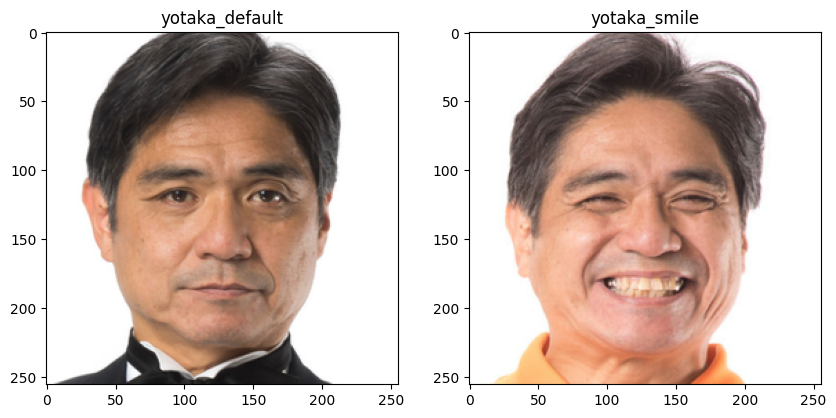

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i in range(2):
    ax[i].imshow(batch[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i].set_title(name_batch[i])
plt.show()

In [20]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [21]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
# alpha[:, None] = alpha.unsqueeze(dim=1)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

In [25]:
preds = []
for i in range(len(alpha)):
    pred = model.render(intp_x[i,None], intp[i,None], T=20)
    preds.append(pred[0])

In [77]:
preds_z = []
for i in range(len(alpha)):
    pred = model.render(intp_x[0,None], intp[i,None], T=20)
    preds_z.append(pred[0])

In [78]:
preds_xt = []
for i in range(len(alpha)):
    pred = model.render(intp_x[i,None], intp[0,None], T=20)
    preds_xt.append(pred[0])

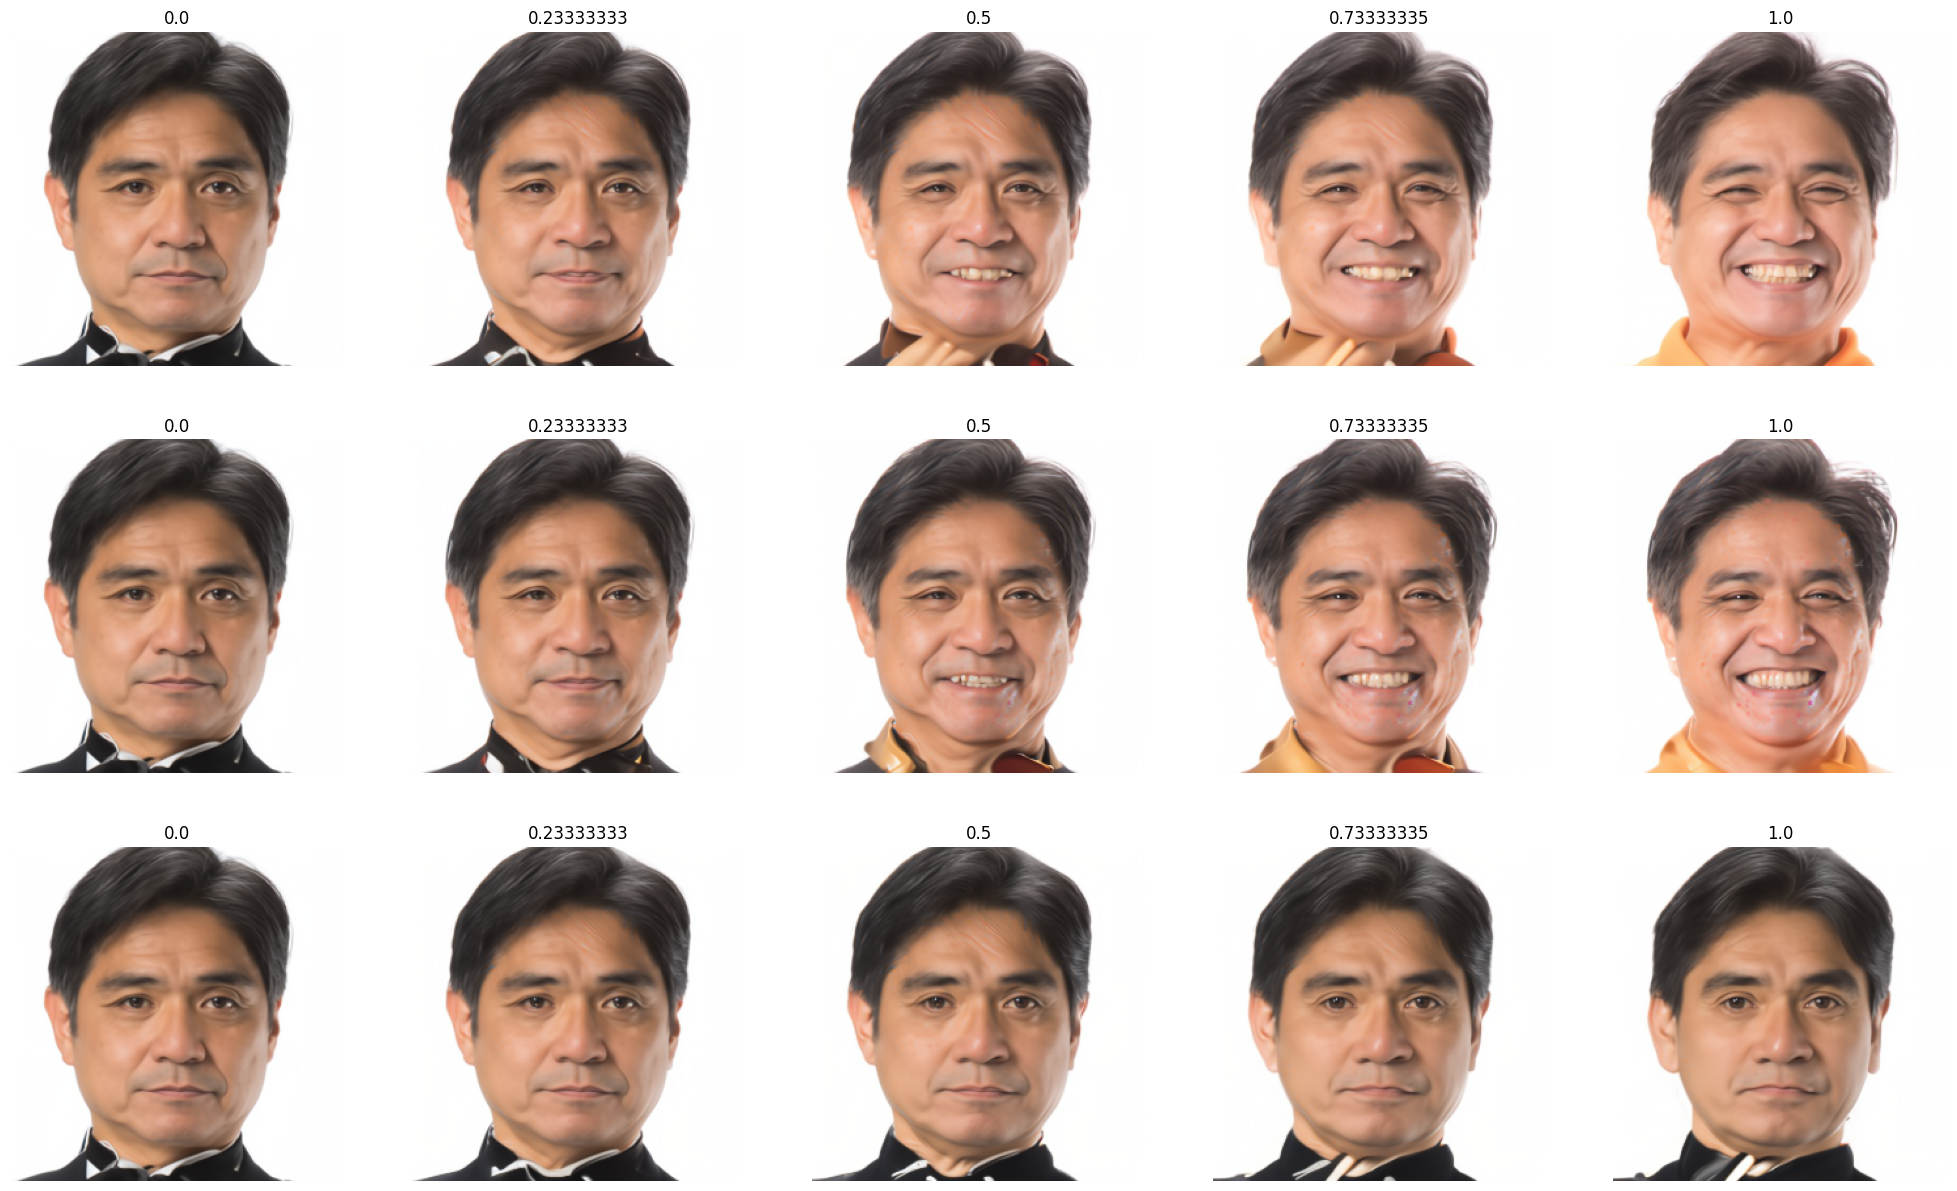

In [91]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(3, num_show, figsize=(5*num_show, 5*3))
for j,k in enumerate(np.linspace(0,len(preds)-1,num_show,dtype=np.uint8)):
    ax[0,j].imshow(preds[k].permute(1,2,0).cpu())
    ax[0,j].set_title(np.array(alpha[k].cpu()))
    ax[0,j].axis('off')
    ax[1,j].imshow(preds_z[k].permute(1,2,0).cpu())
    ax[1,j].set_title(np.array(alpha[k].cpu()))
    ax[1,j].axis('off')
    ax[2,j].imshow(preds_xt[k].permute(1,2,0).cpu())
    ax[2,j].set_title(np.array(alpha[k].cpu()))
    ax[2,j].axis('off')

dst_dir = "imgs_interpolate/test/"
frs_dir = f"{dst_dir}{name_batch[1]}2{name_batch[0]}/"
if not os.path.exists(frs_dir): os.makedirs(frs_dir)
plt.savefig(f"{frs_dir}fig.png")

In [81]:
from PIL import Image

preds_pil = []
for p in preds:
    p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    preds_pil.append(Image.fromarray(p_np))

preds_z_pil = []
for p in preds_z:
    p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    preds_z_pil.append(Image.fromarray(p_np))

preds_xt_pil = []
for p in preds_xt:
    p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    preds_xt_pil.append(Image.fromarray(p_np))

In [82]:
dst_dir = "imgs_interpolate/test/"

frs_dir = f"{dst_dir}{name_batch[1]}2{name_batch[0]}/normal/"
if not os.path.exists(frs_dir): os.makedirs(frs_dir)
file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
dst_path = frs_dir + file_name

preds_pil[0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil,
    duration=4000//(len(alpha)),
    loop=0,
)

In [83]:
from torchvision.utils import save_image

alpha_slice = range(0, len(alpha), 3)
select_ind = set(alpha_slice)
dst_dir = "imgs_interpolate/test/"
frs_dir = f"{dst_dir}{name_batch[1]}2{name_batch[0]}/normal/"
if not os.path.exists(frs_dir): os.makedirs(frs_dir)
for j,p in enumerate(preds):
    if j in select_ind:
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

In [84]:
dst_dir = "imgs_interpolate/test/"

frs_dir = f"{dst_dir}{name_batch[1]}2{name_batch[0]}/zsem_only/"
if not os.path.exists(frs_dir): os.makedirs(frs_dir)
file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
dst_path = frs_dir + file_name

preds_pil[0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil,
    duration=4000//(len(alpha)),
    loop=0,
)

In [85]:
from torchvision.utils import save_image

alpha_slice = range(0, len(alpha), 3)
select_ind = set(alpha_slice)
dst_dir = "imgs_interpolate/test/"
frs_dir = f"{dst_dir}{name_batch[1]}2{name_batch[0]}/zsem_only/"
if not os.path.exists(frs_dir): os.makedirs(frs_dir)
for j,p in enumerate(preds):
    if j in select_ind:
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

In [86]:
dst_dir = "imgs_interpolate/test/"

frs_dir = f"{dst_dir}{name_batch[1]}2{name_batch[0]}/xT_only/"
if not os.path.exists(frs_dir): os.makedirs(frs_dir)
file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
dst_path = frs_dir + file_name

preds_pil[0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil,
    duration=4000//(len(alpha)),
    loop=0,
)

In [87]:
from torchvision.utils import save_image

alpha_slice = range(0, len(alpha), 3)
select_ind = set(alpha_slice)
dst_dir = "imgs_interpolate/test/"
frs_dir = f"{dst_dir}{name_batch[1]}2{name_batch[0]}/xT_only/"
if not os.path.exists(frs_dir): os.makedirs(frs_dir)
for j,p in enumerate(preds):
    if j in select_ind:
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')